In [88]:
import time
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from imutils.video import VideoStream
from imutils.video import FPS
import argparse
import imutils

from math import atan2, degrees

In [3]:
# construct the argument parser and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-v", "--video", type=str,
	help="path to input video file")
ap.add_argument("-t", "--tracker", type=str, default="csrt",
	help="OpenCV object tracker type")
args = vars(ap.parse_known_args()[0])
#################
(major, minor) = cv2.__version__.split(".")[:2]
if int(major) == 3 and int(minor) < 3:
	tracker = cv2.Tracker_create(args["tracker"].upper())
else:
	OPENCV_OBJECT_TRACKERS = {
		"csrt": cv2.TrackerCSRT_create,
		"kcf": cv2.TrackerKCF_create,
		# "boosting": cv2.TrackerBoosting_create,
		"mil": cv2.TrackerMIL_create,
		# "tld": cv2.TrackerTLD_create,
		# "medianflow": cv2.TrackerMedianFlow_create,
		# "mosse": cv2.TrackerMOSSE_create
	}
	tracker = OPENCV_OBJECT_TRACKERS[args["tracker"]]()

In [78]:
df = pd.DataFrame(columns = ['label', 'time', 'x', 'y'])
vs = cv2.VideoCapture("../test_videos/test_4.mp4")
kernel = np.ones((5,5),np.uint8)
first_frame = True
eps = 200

frame_width = int(vs.get(3))
frame_height = int(vs.get(4))
size = (frame_width, frame_height)

fourcc = cv2.VideoWriter_fourcc(*'XVID')
fps = vs.get(cv2.CAP_PROP_FPS)
result = cv2.VideoWriter('labeled_both.mp4', 
                         fourcc,
                         fps, size)

initBB = None
circle_coords = []
while True:
	# grab the current frame, then handle if we are using a
	# VideoStream or VideoCapture object
	frame = vs.read()[1]
	if frame is None:
		break
	(H, W) = frame.shape[:2]
	################# preprocessing
	bgr = frame
	hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
	l_range = np.array([40, 40, 40])
	u_range = np.array([70, 255, 255])
	mask = cv2.inRange(hsv, l_range, u_range)
	mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
	###########################
	contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	label = '0'
	for cnt in contours:
		color = (0,255,0)
		check = 0
		x,y,w,h = cv2.boundingRect(cnt)
		if w*h > 400 and y >= H/4:
			check += 1
			curr_time = vs.get(cv2.CAP_PROP_POS_MSEC)
			if first_frame:
				x1 = x+w/2
				y1 = y+h/2
				first_frame = False
			else:
				diff_x = abs(x1 - (x+w/2))
				diff_y = abs(y1 - (y+h/2))
				if diff_x+diff_y < eps:
					label = '0'
					x1 = x+w/2
					y1 = y+h/2
				else:
					label = '1'
			df.loc[df.shape[0]] = [label, curr_time/1000, x+w/2, y+h/2] 
			cv2.rectangle(frame,(x,y),(x+w,y+h),color,2)	
			cv2.putText(frame, label, (int(x+w/2), int(y+h/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)		
	if initBB is not None:
		# grab the new bounding box coordinates of the object
		(success, box) = tracker.update(frame)
		# check to see if the tracking was a success
		if success:
			(x, y, w, h) = [int(v) for v in box]
			# cv2.rectangle(frame, (x, y), (x + w, y + h),(0, 255, 0), 2)
			curr_time = vs.get(cv2.CAP_PROP_POS_MSEC)
			df.loc[df.shape[0]] = ['Center', curr_time/1000, x+w/2, y+h/2]
			circle_coords.append((int(x+w/2),int(y+h/2)))
			for xy in circle_coords:
				cv2.circle(frame, xy, 1, (255, 0, 0), 1)
		# update the FPS counter
		fps.update()
		fps.stop()
		# initialize the set of information we'll be displaying on
		# the frame
		# info = [
		# 	("Tracker", args["tracker"]),
		# 	("Success", "Yes" if success else "No"),
		# 	("FPS", "{:.2f}".format(fps.fps())),
		# ]
		# # loop over the info tuples and draw them on our frame
		# for (i, (k, v)) in enumerate(info):
		# 	text = "{}: {}".format(k, v)
		# 	cv2.putText(frame, text, (10, H - ((i * 20) + 20)),
		# 		cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
		# show the output frame

	cv2.imshow('Frame', frame)
	result.write(frame)
	if check > 2:
		print(curr_time)
	# cv2.imshow('Mask', mask)
	key = cv2.waitKey(1) & 0xFF

	# if key == ord("s"):
	if initBB == None:
		# select the bounding box of the object we want to track (make
		# sure you press ENTER or SPACE after selecting the ROI)
		initBB = cv2.selectROI("Frame", frame, fromCenter=False,
			showCrosshair=True)
		# start OpenCV object tracker using the supplied bounding box
		# coordinates, then start the FPS throughput estimator as well
		tracker.init(frame, initBB)
		fps = FPS().start()
			# if the `q` key was pressed, break from the loop
	elif key == ord("q"):
		break
vs.release()
result.release()
# close all windows
cv2.destroyAllWindows()

In [17]:
df0 = df[df.label == '0']
df1 = df[df.label == '1']
df_c = df[df.label == 'Center']

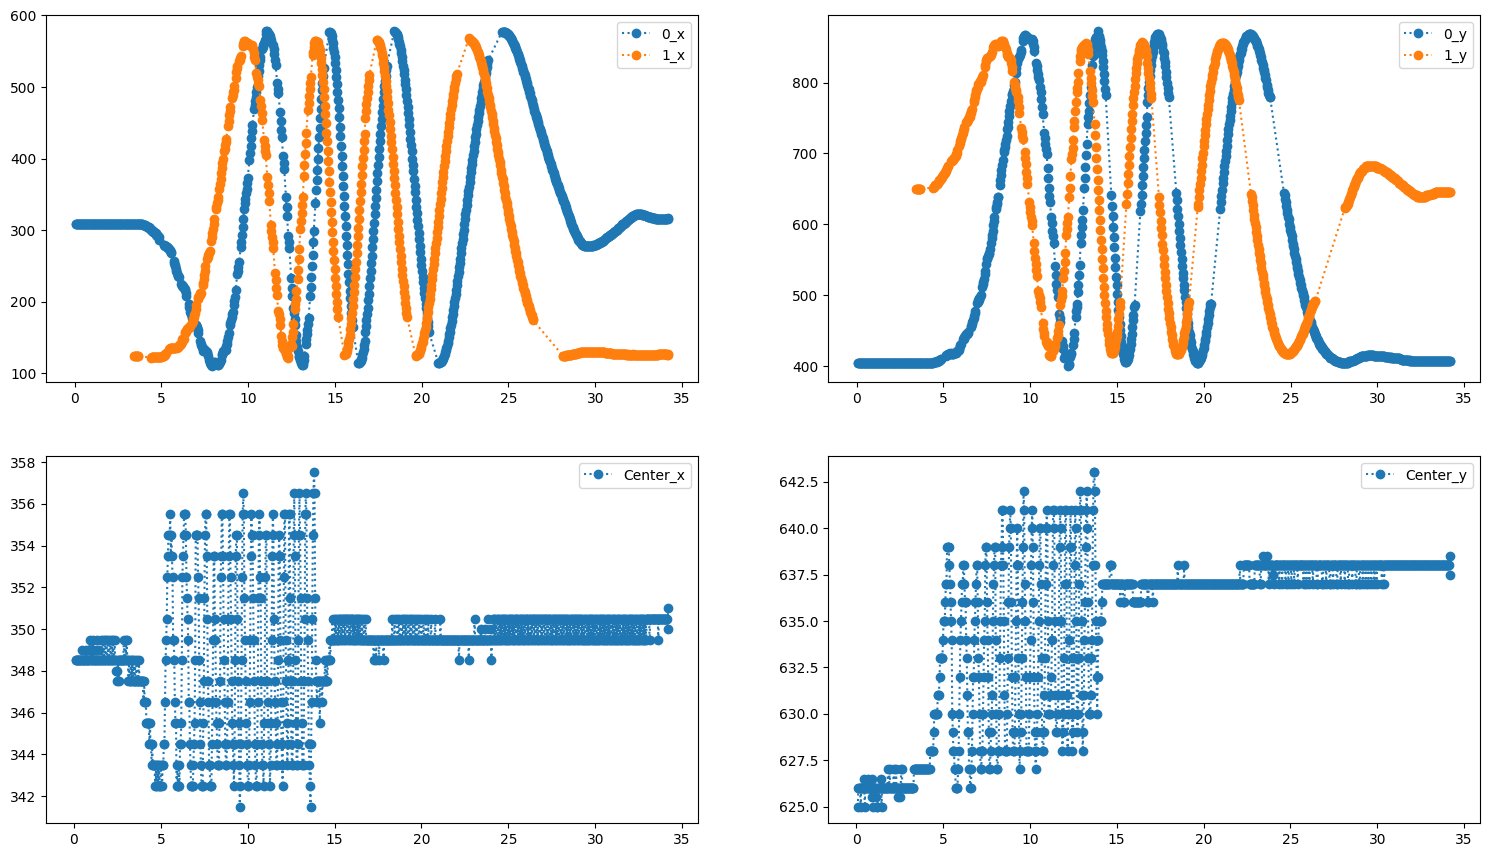

In [45]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_size_inches(18.5, 10.5)
ax1.plot(df0['time'], df0['x'], ':o', label = '0_x')
ax1.plot(df1['time'], df1['x'], ':o', label = '1_x')
ax1.legend()
ax2.plot(df0['time'], df0['y'], ':o',label = '0_y')
ax2.plot(df1['time'], df1['y'], ':o',label = '1_y')
ax2.legend()
ax3.plot(df_c['time'], df_c['x'],':o',label = 'Center_x')
ax3.legend()
ax4.plot(df_c['time'], df_c['y'], ':o',label = 'Center_y')
ax4.legend()

Angle conversion

In [79]:
origin_x = df[df.label == 'Center']['x'].iloc[0]
origin_y = df[df.label == 'Center']['y'].iloc[0]

In [94]:
df_rel = df.copy()
df_rel['x'] = df_rel['x'] - origin_x
df_rel['y'] = origin_y - df_rel['y']
df_rel['theta'] = df['x']
for i in range(df_rel.shape[0]):
    df_rel['theta'].iloc[i] = atan2(df_rel['y'].iloc[i], df_rel['x'].iloc[i])
df_rel['theta'] = df_rel['theta'].apply(degrees)

C:\Temp\ipykernel_5188\2354987336.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rel['theta'].iloc[i] = atan2(df_rel['y'].iloc[i], df_rel['x'].iloc[i])


In [98]:
delta_theta = abs(df_rel[df_rel.label == '0']['theta'].iloc[0]) - abs(df_rel[df_rel.label == '1']['theta'].iloc[0])

In [99]:
delta_theta

-73.2470585308005